In [1]:
import sys
sys.path.append('../../_common/database_communicator/')

In [2]:
from db_connector import DBConnector
import pandas as pd

In [3]:
connector = DBConnector()
engine = connector.create_sql_engine()

In [4]:
df = pd.read_sql_query("SELECT * FROM data_staging", con=engine)

In [13]:
df['price'] = df['price'].str.replace('zł', '').str \
    .replace(' ', '') \
    .replace(',', '.', regex=True) \
    .replace('Zapytajocenę', None, regex=True) \
    .astype(float)

In [17]:
df['size']= df['size'].str.replace(',', '.').astype(float)

In [28]:
df.head()

,url,price,status,size,property_type,rooms,floor,year_built,property_condition,location,desc,image_url
0,https://www.otodom.pl/pl/oferta/nowoczesne-dwu...,630000.0,wtórny,68.00,brak informacji,2,1/6,brak informacji,do zamieszkania,"ul. Chartowo, Chartowo, Nowe Miasto, Poznań, w...",Z przyjemnością przedstawiam ofertę sprzedaży ...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...
1,https://www.otodom.pl/pl/oferta/nowe-3-pokoje-...,552520.0,pierwotny,51.00,blok,3,1,2023,do wykończenia,"Starołęka Mała, Nowe Miasto, Poznań, wielkopol...",Możliwość kontaktu telefonicznego w godzinach ...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...
2,https://www.olx.pl/d/oferta/mieszkanie-3-pokoj...,649000.0,wtórny,59.00,blok,3,1,None,None,"Poznań, Naramowice\nWielkopolskie",Zamieszkaj w dzielnicy Poznania blisko natury!...,https://ireland.apollo.olxcdn.com:443/v1/files...
3,https://www.otodom.pl/pl/oferta/wynajety-apart...,679000.0,pierwotny,41.92,apartamentowiec,2,5/5,2023,zapytaj,"Łacina, Nowe Miasto, Poznań, wielkopolskie",Oferta bezpośrednio od właściciela – BRAK prow...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...
4,https://www.otodom.pl/pl/oferta/atrakcyjne-mie...,679000.0,wtórny,43.65,kamienica,2,3/4,1900,do zamieszkania,"ul. Tylne Chwaliszewo, Chwaliszewo, Stare Mias...",* Stylowo urządzone * CHWALISZEWO *\n\nPrzedst...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...


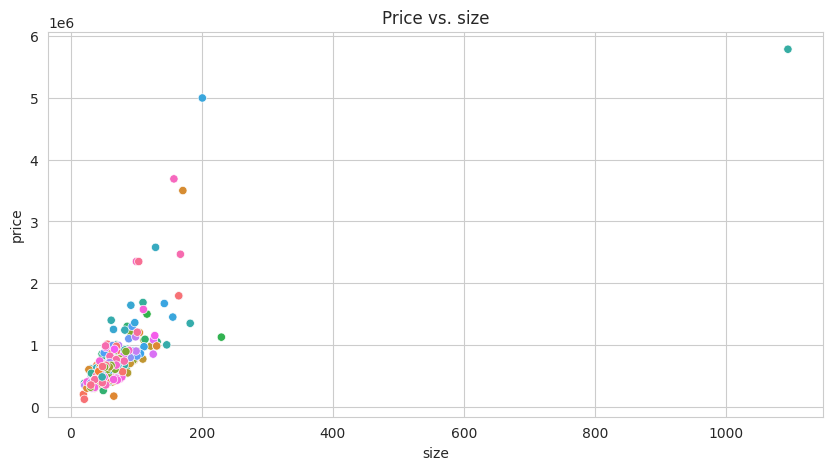

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.scatterplot(x='size', y='price', data=df, hue='location', legend=False)
plt.title('Price vs. size')
plt.show()

In [33]:
df[df['size'] > 1000]

,url,price,status,size,property_type,rooms,floor,year_built,property_condition,location,desc,image_url
219,https://www.otodom.pl/pl/oferta/cala-kamienica...,5790000.0,wtórny,1094.0,kamienica,None,parter/5,1939,do zamieszkania,"ul. Kanałowa, Łazarz, Grunwald, Poznań, wielko...",Oferujemy do sprzedaży atrakcyjną kamienicę po...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...


In [35]:
df = df[df['price'].notna()]

In [84]:
from sklearn.ensemble import IsolationForest
import numpy as np

clf = IsolationForest(max_samples=5, contamination=0.005, random_state=42).fit(df[['size', 'price']])

clf.predict(df[['size', 'price']])
df['outlier'] = clf.predict(df[['size', 'price']])

print(len(df))
print(len(df[df['outlier'] == -1]))

521
1


/tmp/ipykernel_18619/2024772708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier'] = clf.predict(df[['size', 'price']])


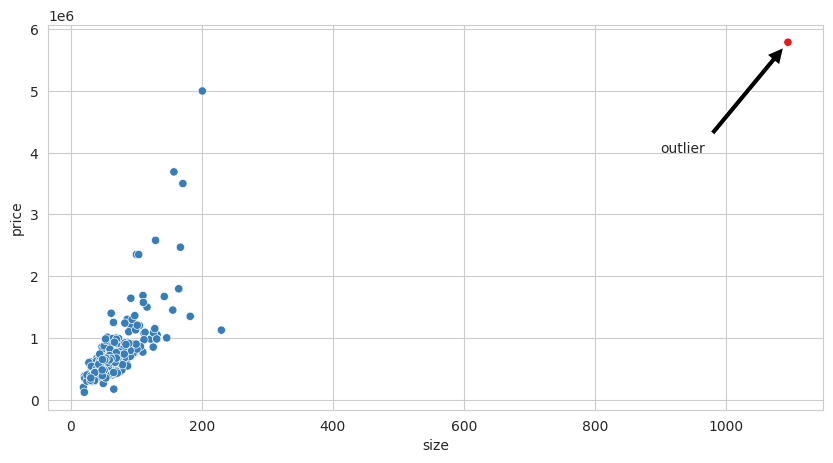

In [91]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.scatterplot(x='size', y='price', data=df, hue='outlier', legend=False, palette='Set1')
plt.annotate('outlier', xy=(1094.0, 5790000.0), xytext=(900, 4000000), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()